# 오픈소스 SW 활용 기말 프로젝트
#### 32202341 송지윤

### 주제: COVID-19와 cryptocurrency market의 상관 관계 분석 
- 2020년 3월부터 2022년 3월까지의 미국의 COVID pandemic이 암호화폐 시장에 영향을 주었을 것이라 가정한다.
- 미국의 전체 코로나 상황 데이터와 CoinGecko API의 암호화폐 변화 데이터를 비교한다.
- 암호화폐 데이터는 현재 시가총액이 가장 높은 상위 5개의 데이터로 선정한다.

# Data 전처리 및 가공

### OWID의 Data on COVID-19 (coronavirus)
- Download our complete COVID-19 dataset -> CSV file 다운로드 -> owid-covid-data.csv
- https://github.com/owid/covid-19-data/tree/master/public/data


### Data read

In [848]:
# import moudle cell

import pandas as pd
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import datetime

In [849]:
# CSV파일 읽어 오기
df_owid = pd.read_csv('owid-covid-data.csv')

df_owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318399 entries, 0 to 318398
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    318399 non-null  object 
 1   continent                                   303273 non-null  object 
 2   location                                    318399 non-null  object 
 3   date                                        318399 non-null  object 
 4   total_cases                                 282164 non-null  float64
 5   new_cases                                   309582 non-null  float64
 6   new_cases_smoothed                          308318 non-null  float64
 7   total_deaths                                261272 non-null  float64
 8   new_deaths                                  309633 non-null  float64
 9   new_deaths_smoothed                         308403 non-null  float64
 

### column 확인 및 filtered 데이터프레임 생성
- iso_code : 국제 표준 국가 코드
- location : 국가 이름
- date : 일자
- total_cases : 전체 확진자 수
- population : 인구

In [850]:
df_owid_filtered=df_owid[['iso_code', 'location', 'date', 'total_cases', 'population']]
df_owid_filtered

,iso_code,location,date,total_cases,population
0,AFG,Afghanistan,2020-01-03,NaN,41128772.0
1,AFG,Afghanistan,2020-01-04,NaN,41128772.0
2,AFG,Afghanistan,2020-01-05,NaN,41128772.0
3,AFG,Afghanistan,2020-01-06,NaN,41128772.0
4,AFG,Afghanistan,2020-01-07,NaN,41128772.0
...,...,...,...,...,...
318394,ZWE,Zimbabwe,2023-06-10,265161.0,16320539.0
318395,ZWE,Zimbabwe,2023-06-11,265161.0,16320539.0
318396,ZWE,Zimbabwe,2023-06-12,265289.0,16320539.0
318397,ZWE,Zimbabwe,2023-06-13,265289.0,16320539.0


In [851]:
# 데이터프레임에서 미국 데이터를 추출하기 위해 지역 데이터 추출
location = df_owid['location'].unique()
location

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia', 'Australia', 'Austria',
       'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Eritrea',

In [852]:
# 미국 데이터 프레임 생성
df_usa = df_owid_filtered[df_owid_filtered.location=='United States']

df_usa.head()

,iso_code,location,date,total_cases,population
299596,USA,United States,2020-01-03,NaN,338289856.0
299597,USA,United States,2020-01-04,NaN,338289856.0
299598,USA,United States,2020-01-05,NaN,338289856.0
299599,USA,United States,2020-01-06,NaN,338289856.0
299600,USA,United States,2020-01-07,NaN,338289856.0


In [853]:
# 결측치 제거
df_usa=df_usa.dropna()
df_usa

,iso_code,location,date,total_cases,population
299613,USA,United States,2020-01-20,1.0,338289856.0
299614,USA,United States,2020-01-21,1.0,338289856.0
299615,USA,United States,2020-01-22,1.0,338289856.0
299616,USA,United States,2020-01-23,1.0,338289856.0
299617,USA,United States,2020-01-24,1.0,338289856.0
...,...,...,...,...,...
300850,USA,United States,2023-06-10,103436829.0,338289856.0
300851,USA,United States,2023-06-11,103436829.0,338289856.0
300852,USA,United States,2023-06-12,103436829.0,338289856.0
300853,USA,United States,2023-06-13,103436829.0,338289856.0


In [854]:
# index 변경
df_usa_indexed=df_usa.set_index('date')
df_usa_indexed

,iso_code,location,total_cases,population
date,,,,
2020-01-20,USA,United States,1.0,338289856.0
2020-01-21,USA,United States,1.0,338289856.0
2020-01-22,USA,United States,1.0,338289856.0
2020-01-23,USA,United States,1.0,338289856.0
2020-01-24,USA,United States,1.0,338289856.0
...,...,...,...,...
2023-06-10,USA,United States,103436829.0,338289856.0
2023-06-11,USA,United States,103436829.0,338289856.0
2023-06-12,USA,United States,103436829.0,338289856.0


In [855]:
# 기간 변경
df_usa_indexed=df_usa_indexed.loc['2020-03-01':'2022-03-31']
df_usa_indexed

,iso_code,location,total_cases,population
date,,,,
2020-03-01,USA,United States,73.0,338289856.0
2020-03-02,USA,United States,82.0,338289856.0
2020-03-03,USA,United States,100.0,338289856.0
2020-03-04,USA,United States,135.0,338289856.0
2020-03-05,USA,United States,186.0,338289856.0
...,...,...,...,...
2022-03-27,USA,United States,79303178.0,338289856.0
2022-03-28,USA,United States,79315689.0,338289856.0
2022-03-29,USA,United States,79325442.0,338289856.0


In [856]:
df_usa_total_cases = df_usa_indexed['total_cases']
df_usa_total_cases

date
2020-03-01          73.0
2020-03-02          82.0
2020-03-03         100.0
2020-03-04         135.0
2020-03-05         186.0
                 ...    
2022-03-27    79303178.0
2022-03-28    79315689.0
2022-03-29    79325442.0
2022-03-30    79357869.0
2022-03-31    79381947.0
Name: total_cases, Length: 761, dtype: float64

<Axes: xlabel='date'>

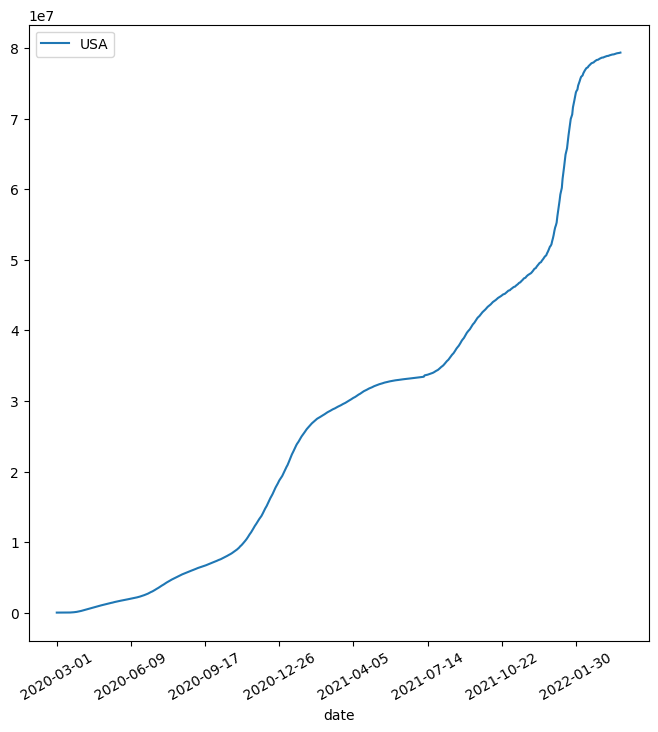

In [857]:
final_df = pd.DataFrame({
    'USA' : df_usa_total_cases
    }, index=df_usa_indexed.index)

final_df.plot.line(rot=30)

### CoinGecko API의 open API 사용
- https://www.coingecko.com/ko/api/documentation

### Data read

In [858]:
# 현재 암호화폐별 가격 데이터프레임 생성

# 현재 암호화폐 시세 API endpoint
url_coinprice = "https://api.coingecko.com/api/v3/coins/markets"

# 파라미터 설정
params = {
    "vs_currency": "krw",  
    "order": "market_cap_desc",
    "per_page": 100,       # 한 페이지 당 보여지는 코인 수 
    "page": 1              # 페이지 1의 코인
}

# 받아온 데이터로 데이터프레임 생성
response = requests.get(url_coinprice, params=params)
data_coinprice = response.json()
df_price=pd.DataFrame(data_coinprice)

df_price.head()


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,33822064.00,656267985288166,1,7.101948e+14,9.837374e+12,34011171.00,...,2.100000e+07,21000000.0,81339064.00,-58.42244,2021-11-10T14:24:11.849Z,75594.00,44637.53478,2013-07-05T00:00:00.000Z,None,2023-06-18T09:22:23.678Z
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2206836.00,265251645857129,2,2.652516e+14,5.013018e+12,2229271.00,...,1.202109e+08,NaN,5790811.00,-61.89674,2021-11-08T23:48:45.609Z,489.40,450751.72204,2015-10-20T00:00:00.000Z,"{'times': 86.22589970461762, 'currency': 'btc'...",2023-06-18T09:22:15.690Z
2,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1276.63,106182651845217,3,1.061827e+14,1.522129e+13,1280.17,...,8.317388e+10,NaN,1499.66,-14.87186,2018-07-24T00:00:00.000Z,656.75,94.38779,2015-03-02T00:00:00.000Z,None,2023-06-18T09:20:00.471Z
3,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,314545.00,49017827893652,4,6.290176e+13,6.234516e+11,315126.00,...,1.579002e+08,200000000.0,792895.00,-60.33414,2021-11-07T10:13:53.906Z,44.95,699570.35042,2017-10-19T00:00:00.000Z,None,2023-06-18T09:22:20.770Z
4,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,1276.86,36194904152796,5,3.619490e+13,2.231883e+12,1279.72,...,2.834904e+10,NaN,1466.80,-12.95236,2022-09-30T02:11:16.560Z,1008.25,26.63628,2021-05-19T13:14:05.611Z,None,2023-06-18T09:22:23.689Z


### column 확인 및 filtered 데이터프레임 생성
- id : 암호화폐 id
- symbol : 암호화폐 symbol
- name : 암호화폐 이름
- current_price : 현재 가격
- market_cap : 시가 총액
- market_cap_rank: 시가 총액 순위

In [859]:
# 필요 데이터만 추출하여 filtered 데이터프레임 생성
df_price_filtered=df_price[['id', 'symbol', 'name', 'current_price', 'market_cap', 'market_cap_rank']]
df_price_filtered

,id,symbol,name,current_price,market_cap,market_cap_rank
0,bitcoin,btc,Bitcoin,33822064.00,656267985288166,1
1,ethereum,eth,Ethereum,2206836.00,265251645857129,2
2,tether,usdt,Tether,1276.63,106182651845217,3
3,binancecoin,bnb,BNB,314545.00,49017827893652,4
4,usd-coin,usdc,USD Coin,1276.86,36194904152796,5
...,...,...,...,...,...,...
95,frax-ether,frxeth,Frax Ether,2200795.00,501099404098,96
96,mina-protocol,mina,Mina Protocol,541.43,497797649201,97
97,conflux-token,cfx,Conflux,237.00,496917972676,98
98,kaspa,kas,Kaspa,27.26,490201892618,99


#### wordcloud와 treemap으로 암호화폐 순위 예측

##### treemap

In [860]:
# treemap
fig = px.treemap(df_price_filtered, path=['name'], values='market_cap')
fig.show()

##### wordcloud

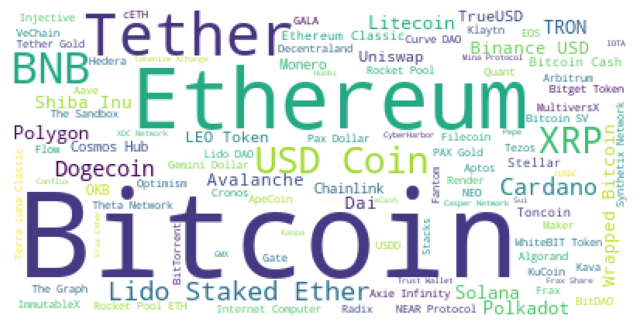

In [861]:
# wordcloud

# 암호화폐 별 시가총액 데이터프레임 추출
df_listed=df_price_filtered[['name', 'market_cap']]
# 데이터프레임 인덱스 변경
df_listed=df_listed.set_index('name')
# 데이터프레임을 series로 변경
df_sereies=df_listed.squeeze()

# wordcloud 그리기
wordcloud_py = WordCloud(background_color = 'white').generate_from_frequencies(df_sereies.to_dict())

plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(wordcloud_py)
plt.axis('off')
plt.show()

In [862]:
# 현재 시가 총액이 가장 높은 상위 5개 암호화폐 데이터프레임 생성
df_cointop10=df_price_filtered.head(5)
df_cointop10

,id,symbol,name,current_price,market_cap,market_cap_rank
0,bitcoin,btc,Bitcoin,33822064.00,656267985288166,1
1,ethereum,eth,Ethereum,2206836.00,265251645857129,2
2,tether,usdt,Tether,1276.63,106182651845217,3
3,binancecoin,bnb,BNB,314545.00,49017827893652,4
4,usd-coin,usdc,USD Coin,1276.86,36194904152796,5


### Bitcoin의 변화 데이터 추출 후 그래프 그리기

In [863]:
# 기간 설정
start_date = datetime.datetime(2020, 3, 1)
end_date = datetime.datetime(2022, 3, 31)

In [864]:
# BTD's API endpoint
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range"

params = {
    "vs_currency": "usd",                      
    "from": int(start_date.timestamp()),
    "to": int(end_date.timestamp())                         
}

response = requests.get(url, params=params)

# Error exception 
if response.status_code == 200:
    data = response.json()
    
    # 비트코인 가격 정보 데이터프레임 생성
    prices = data["prices"]
    df_bitcoin=pd.DataFrame(prices)

else:
    print(f"Error retrieving Bitcoin price data: {response.status_code}")

df_bitcoin


,0,1
0,1583020800000,8552.989119
1,1583107200000,8567.802249
2,1583193600000,8905.876104
3,1583280000000,8756.718577
4,1583366400000,8758.646993
...,...,...
755,1648252800000,44331.777957
756,1648339200000,44510.844218
757,1648425600000,46715.117619
758,1648512000000,46994.879118


In [865]:
df_bitcoin.columns=['timestamp', 'price']

for index, timestamp in enumerate(df_bitcoin['timestamp']):

    dt_object = datetime.datetime.fromtimestamp(timestamp/1000)
    formatted_date = dt_object.strftime("%Y-%m-%d")

    df_bitcoin.at[index, 'timestamp'] = formatted_date

print(df_bitcoin)


      timestamp         price
0    2020-03-01   8552.989119
1    2020-03-02   8567.802249
2    2020-03-03   8905.876104
3    2020-03-04   8756.718577
4    2020-03-05   8758.646993
..          ...           ...
755  2022-03-26  44331.777957
756  2022-03-27  44510.844218
757  2022-03-28  46715.117619
758  2022-03-29  46994.879118
759  2022-03-30  47459.261238

[760 rows x 2 columns]


In [866]:
df_bitcoin=df_bitcoin.rename(columns={'timestamp':'date'})
df_bitcoin

,date,price
0,2020-03-01,8552.989119
1,2020-03-02,8567.802249
2,2020-03-03,8905.876104
3,2020-03-04,8756.718577
4,2020-03-05,8758.646993
...,...,...
755,2022-03-26,44331.777957
756,2022-03-27,44510.844218
757,2022-03-28,46715.117619
758,2022-03-29,46994.879118


<Axes: xlabel='date'>

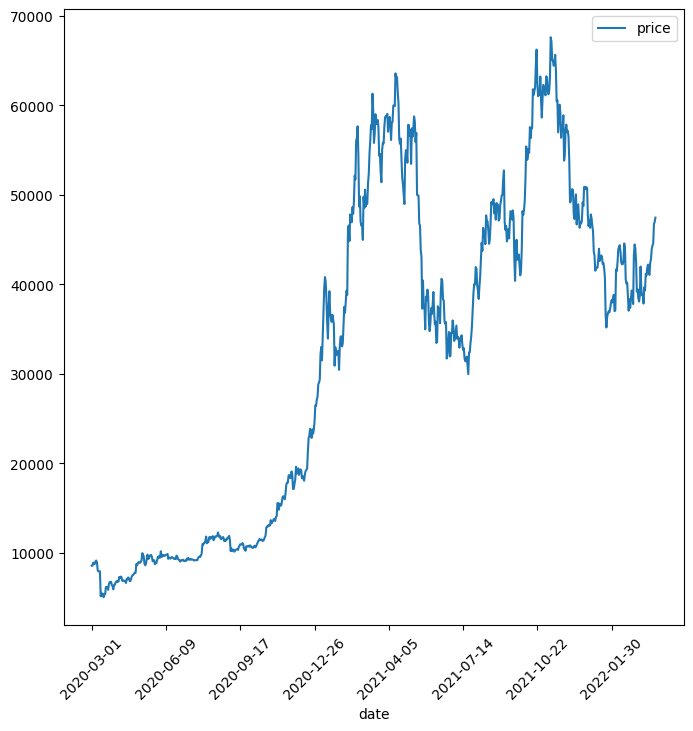

In [867]:
df_bitcoin=df_bitcoin.set_index('date')
df_bitcoin.plot(kind='line', rot=45)

In [868]:
# 기간 내 하루 별 가격 변동 정도를 보여주는 데이터프레임 생성

# 날짜별 변동 정도를 저장하는 리스트 생성
price_changes = []

for i in range(len(prices)-1):
    date = prices[i][0]             # 날짜별 Timestamp 

    # timestamp를 date 형식으로 변환
    dt_object = datetime.datetime.fromtimestamp(date/1000)
    formatted_date = dt_object.strftime("%Y-%m-%d")

    price_today = prices[i][1]      # 날짜별 가격
    price_tomorrow = prices[i+1][1] # 다음날 가격
    daily_change = price_tomorrow - price_today
    price_changes.append((formatted_date, daily_change))

price_changes

[('2020-03-01', 14.813130097589237),
 ('2020-03-02', 338.07385558296846),
 ('2020-03-03', -149.15752751964465),
 ('2020-03-04', 1.9284164493674325),
 ('2020-03-05', 280.22333004150823),
 ('2020-03-06', 96.97474279978451),
 ('2020-03-07', -233.64311592531885),
 ('2020-03-08', -860.8364120360557),
 ('2020-03-09', -120.0335311611143),
 ('2020-03-10', -14.600478400087923),
 ('2020-03-11', 28.790511659912227),
 ('2020-03-12', -2792.5315811522287),
 ('2020-03-13', 399.82908335483717),
 ('2020-03-14', -328.6304299892354),
 ('2020-03-15', 183.7442450552726),
 ('2020-03-16', -365.43200595146936),
 ('2020-03-17', 356.9144235463691),
 ('2020-03-18', -13.135027188652202),
 ('2020-03-19', 793.9198523922369),
 ('2020-03-20', 25.402905019954233),
 ('2020-03-21', -49.832614005229516),
 ('2020-03-22', -286.1234609530111),
 ('2020-03-23', 596.7000556640305),
 ('2020-03-24', 273.8262964077694),
 ('2020-03-25', -34.27316397346476),
 ('2020-03-26', 69.66146053218654),
 ('2020-03-27', -367.7357506043063),
 

In [869]:
df_price_changes = pd.DataFrame(price_changes, columns=["Date", "Price Change"])
df_price_changes

,Date,Price Change
0,2020-03-01,14.813130
1,2020-03-02,338.073856
2,2020-03-03,-149.157528
3,2020-03-04,1.928416
4,2020-03-05,280.223330
...,...,...
754,2022-03-25,395.681723
755,2022-03-26,179.066261
756,2022-03-27,2204.273401
757,2022-03-28,279.761500


In [870]:
# 데이터프레임의 인덱스를 date로 변경
df_BTD_indexed=df_price_changes.set_index('Date')
df_BTD_indexed

,Price Change
Date,
2020-03-01,14.813130
2020-03-02,338.073856
2020-03-03,-149.157528
2020-03-04,1.928416
2020-03-05,280.223330
...,...
2022-03-25,395.681723
2022-03-26,179.066261
2022-03-27,2204.273401


<Axes: xlabel='Date'>

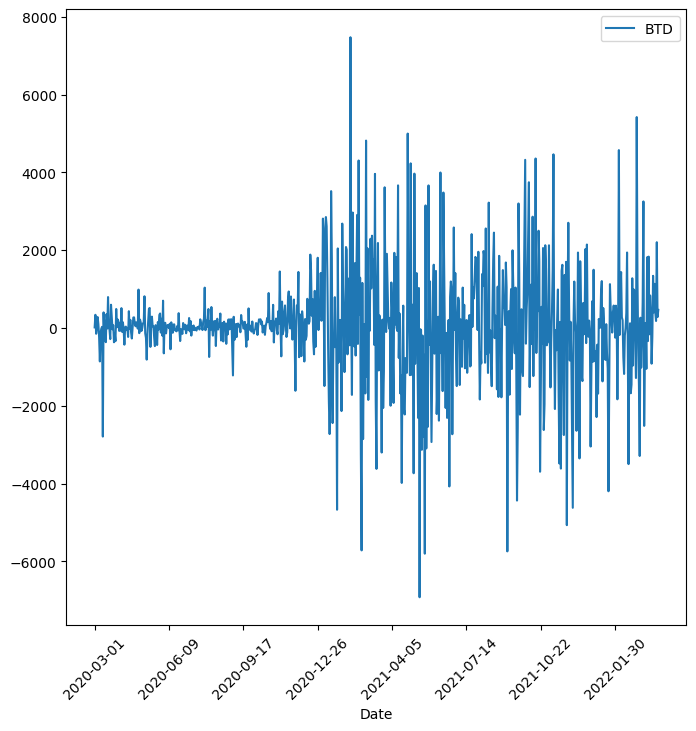

In [871]:
# line graph 그리기
df_BTD=pd.DataFrame({
    'BTD' : df_BTD_indexed['Price Change']
}, index=df_BTD_indexed.index)

df_BTD.plot.line(rot=45)

### 현재 시가 총액이 가장 높은 상위 5개 암호화폐의 기간 내 데이터 받아오기

In [872]:
# 현재 암호화폐 시세 API endpoint
url = "https://api.coingecko.com/api/v3/coins/markets"

params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 5,  # Top 5 암호화폐
    "page": 1
}

response = requests.get(url, params=params)

# Error check
if response.status_code == 200:
    data = response.json()

    # 암호화폐 이름, id, symbol 저장
    crypto_symbols = [coin["symbol"].upper() for coin in data]
    crypto_names = [coin["name"] for coin in data]
    crypto_ids=[coin['id'] for coin in data]

else:
    print("Error occurred while fetching data:", response.text)

In [873]:
print(crypto_ids)
print(crypto_names)
print(crypto_symbols)

['bitcoin', 'ethereum', 'tether', 'binancecoin', 'usd-coin']
['Bitcoin', 'Ethereum', 'Tether', 'BNB', 'USD Coin']
['BTC', 'ETH', 'USDT', 'BNB', 'USDC']


In [874]:
# 각 암호화폐의 price date dataframe 저장할 dict 선언
dataframes={}

# 10개 암호화폐의 가격 변화 데이터 받아오기
for id in crypto_ids:
    # 암호화폐 별 차트 기록 url
    history_url = f"https://api.coingecko.com/api/v3/coins/{id}/market_chart/range"

    history_params = {
        "vs_currency": "usd",
        "from": int(start_date.timestamp()),
        "to": int(end_date.timestamp())
    }

    history_response = requests.get(history_url, params=history_params)

    # Error check
    if response.status_code == 200:
        history_data = history_response.json()

        if "prices" in history_data:
            prices_data = history_data["prices"]
            
            # 가격 데이터 받아 dict에 저장, key는 df_암호화폐id
            df = pd.DataFrame(prices_data)
            dataframes[f'df_{id}'] = df
        else:
            print(f"Error: 'prices' key not found in the API response for cryptocurrency {id}")
    
    else:
        print(f"Error retrieving Bitcoin price data: {response.status_code}")

In [875]:
# price date dataframe 저장된 dict 확인
dataframes

{'df_bitcoin':                  0             1
 0    1583020800000   8552.989119
 1    1583107200000   8567.802249
 2    1583193600000   8905.876104
 3    1583280000000   8756.718577
 4    1583366400000   8758.646993
 ..             ...           ...
 755  1648252800000  44331.777957
 756  1648339200000  44510.844218
 757  1648425600000  46715.117619
 758  1648512000000  46994.879118
 759  1648598400000  47459.261238
 
 [760 rows x 2 columns],
 'df_ethereum':                  0            1
 0    1583020800000   218.348357
 1    1583107200000   218.939797
 2    1583193600000   231.679446
 3    1583280000000   223.960116
 4    1583366400000   224.134877
 ..             ...          ...
 755  1648252800000  3106.072054
 756  1648339200000  3140.875711
 757  1648425600000  3285.173097
 758  1648512000000  3328.934125
 759  1648598400000  3401.184431
 
 [760 rows x 2 columns],
 'df_tether':                  0         1
 0    1583020800000  0.998755
 1    1583107200000  1.001386
 2    1583

In [876]:
# dict 내용 확인
for name, df in dataframes.items():
    print(name)

df_bitcoin
df_ethereum
df_tether
df_binancecoin
df_usd-coin


In [877]:
dataframes.get('df_bitcoin')

,0,1
0,1583020800000,8552.989119
1,1583107200000,8567.802249
2,1583193600000,8905.876104
3,1583280000000,8756.718577
4,1583366400000,8758.646993
...,...,...
755,1648252800000,44331.777957
756,1648339200000,44510.844218
757,1648425600000,46715.117619
758,1648512000000,46994.879118


In [878]:
dataframes.get('df_tether')

,0,1
0,1583020800000,0.998755
1,1583107200000,1.001386
2,1583193600000,1.000333
3,1583280000000,1.000839
4,1583366400000,1.001649
...,...,...
755,1648252800000,0.999733
756,1648339200000,0.999516
757,1648425600000,0.998782
758,1648512000000,0.997710


In [879]:
for name, df in dataframes.items():
    df= dataframes.get(name)
    df.columns=['timestamp', 'price']
    
    for index, timestamp in enumerate(df['timestamp']):

        dt_object = datetime.datetime.fromtimestamp(timestamp/1000)
        formatted_date = dt_object.strftime("%Y-%m-%d")

        df.at[index, 'timestamp'] = formatted_date


In [880]:
dataframes

{'df_bitcoin':       timestamp         price
 0    2020-03-01   8552.989119
 1    2020-03-02   8567.802249
 2    2020-03-03   8905.876104
 3    2020-03-04   8756.718577
 4    2020-03-05   8758.646993
 ..          ...           ...
 755  2022-03-26  44331.777957
 756  2022-03-27  44510.844218
 757  2022-03-28  46715.117619
 758  2022-03-29  46994.879118
 759  2022-03-30  47459.261238
 
 [760 rows x 2 columns],
 'df_ethereum':       timestamp        price
 0    2020-03-01   218.348357
 1    2020-03-02   218.939797
 2    2020-03-03   231.679446
 3    2020-03-04   223.960116
 4    2020-03-05   224.134877
 ..          ...          ...
 755  2022-03-26  3106.072054
 756  2022-03-27  3140.875711
 757  2022-03-28  3285.173097
 758  2022-03-29  3328.934125
 759  2022-03-30  3401.184431
 
 [760 rows x 2 columns],
 'df_tether':       timestamp     price
 0    2020-03-01  0.998755
 1    2020-03-02  1.001386
 2    2020-03-03  1.000333
 3    2020-03-04  1.000839
 4    2020-03-05  1.001649
 ..       

In [881]:
dataframes.get('df_bitcoin')

,timestamp,price
0,2020-03-01,8552.989119
1,2020-03-02,8567.802249
2,2020-03-03,8905.876104
3,2020-03-04,8756.718577
4,2020-03-05,8758.646993
...,...,...
755,2022-03-26,44331.777957
756,2022-03-27,44510.844218
757,2022-03-28,46715.117619
758,2022-03-29,46994.879118


In [882]:
for name, df in dataframes.items():
    print(name)
    df= dataframes.get(name)
    df=df.rename(columns={'timestamp':'date'}, inplace=True)

df_bitcoin
df_ethereum
df_tether
df_binancecoin
df_usd-coin


In [883]:
dataframes

{'df_bitcoin':            date         price
 0    2020-03-01   8552.989119
 1    2020-03-02   8567.802249
 2    2020-03-03   8905.876104
 3    2020-03-04   8756.718577
 4    2020-03-05   8758.646993
 ..          ...           ...
 755  2022-03-26  44331.777957
 756  2022-03-27  44510.844218
 757  2022-03-28  46715.117619
 758  2022-03-29  46994.879118
 759  2022-03-30  47459.261238
 
 [760 rows x 2 columns],
 'df_ethereum':            date        price
 0    2020-03-01   218.348357
 1    2020-03-02   218.939797
 2    2020-03-03   231.679446
 3    2020-03-04   223.960116
 4    2020-03-05   224.134877
 ..          ...          ...
 755  2022-03-26  3106.072054
 756  2022-03-27  3140.875711
 757  2022-03-28  3285.173097
 758  2022-03-29  3328.934125
 759  2022-03-30  3401.184431
 
 [760 rows x 2 columns],
 'df_tether':            date     price
 0    2020-03-01  0.998755
 1    2020-03-02  1.001386
 2    2020-03-03  1.000333
 3    2020-03-04  1.000839
 4    2020-03-05  1.001649
 ..       

In [884]:
# 날짜별 모든 암호화폐 가격을 저장할 데이터프레임 df_merged_price 생성
df_bitcoin=dataframes.get('df_bitcoin')
df_merged_price=pd.DataFrame()

# dict에 저장된 각 데이터프레임의 열 이름 변경 후 df_merged_price에 {암호화폐 symbol : 날짜별 가격}을 새로운 열로 추가
for symbol, (name, df) in zip(crypto_symbols, dataframes.items()):
    df_merged_price[f'{symbol}']=df['price']

df_merged_price=df_merged_price.set_index(df_bitcoin['date'])

In [885]:
# bitcoin의 가격과 다른 암호화폐의 극심한 가격 편차로 가격 변동률 가시화를 위해 가격 조정
df_merged_price['BTC'] = df_merged_price['BTC'] / 10

<Axes: xlabel='date'>

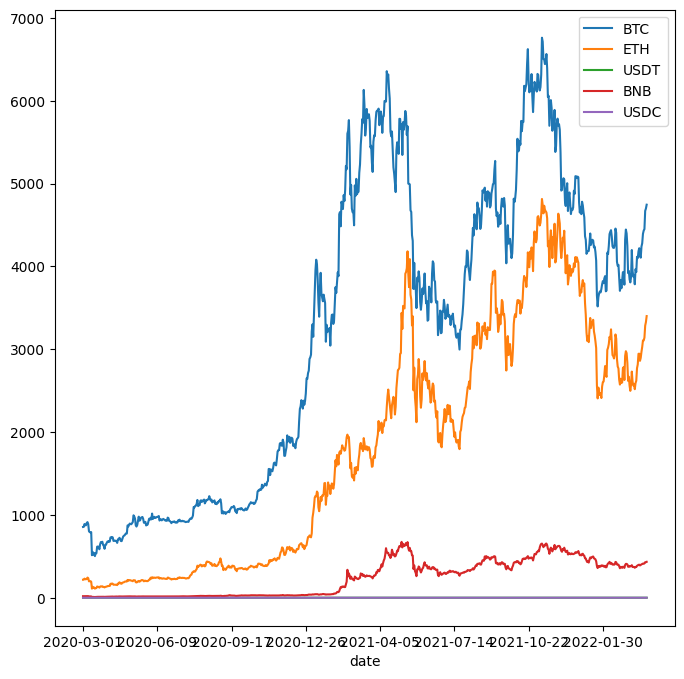

In [886]:
df_merged_price.plot(kind='line')

In [887]:
# 날짜 형식 변환 후 데이터 저장할 dict
dataframes_fixed={}

for symbol, (name, df) in zip(crypto_symbols, dataframes.items()):
    # 날짜별 변동 정도를 저장하는 리스트 생성
    price_changes = []
    df=dataframes.get(name)
    df.columns=['timestamp', 'price']

    for i in range(len(df['timestamp'])-1):
        date = df['timestamp'][i] # 날짜별 Timestamp 

        price_today = df['price'][i]     # 날짜별 가격
        price_tomorrow = df['price'][i+1] # 다음날 가격
        daily_change = price_tomorrow - price_today
        price_changes.append((date, daily_change))
    
        dataframes_fixed[f'df_{symbol}'] = pd.DataFrame(price_changes, columns=["Date", "Price Change"])

In [888]:
dataframes_fixed

{'df_BTC':            Date  Price Change
 0    2020-03-01     14.813130
 1    2020-03-02    338.073856
 2    2020-03-03   -149.157528
 3    2020-03-04      1.928416
 4    2020-03-05    280.223330
 ..          ...           ...
 754  2022-03-25    395.681723
 755  2022-03-26    179.066261
 756  2022-03-27   2204.273401
 757  2022-03-28    279.761500
 758  2022-03-29    464.382119
 
 [759 rows x 2 columns],
 'df_ETH':            Date  Price Change
 0    2020-03-01      0.591440
 1    2020-03-02     12.739649
 2    2020-03-03     -7.719330
 3    2020-03-04      0.174761
 4    2020-03-05      3.946058
 ..          ...           ...
 754  2022-03-25     -0.584969
 755  2022-03-26     34.803656
 756  2022-03-27    144.297386
 757  2022-03-28     43.761028
 758  2022-03-29     72.250306
 
 [759 rows x 2 columns],
 'df_USDT':            Date  Price Change
 0    2020-03-01      0.002632
 1    2020-03-02     -0.001054
 2    2020-03-03      0.000506
 3    2020-03-04      0.000809
 4    2020-03-05

In [889]:
for name, df in dataframes_fixed.items():
    print(name)

df_BTC
df_ETH
df_USDT
df_BNB
df_USDC


In [890]:
dataframes_fixed.get('df_BTC')

,Date,Price Change
0,2020-03-01,14.813130
1,2020-03-02,338.073856
2,2020-03-03,-149.157528
3,2020-03-04,1.928416
4,2020-03-05,280.223330
...,...,...
754,2022-03-25,395.681723
755,2022-03-26,179.066261
756,2022-03-27,2204.273401
757,2022-03-28,279.761500


In [891]:
dataframes_fixed.get('df_ETH')

,Date,Price Change
0,2020-03-01,0.591440
1,2020-03-02,12.739649
2,2020-03-03,-7.719330
3,2020-03-04,0.174761
4,2020-03-05,3.946058
...,...,...
754,2022-03-25,-0.584969
755,2022-03-26,34.803656
756,2022-03-27,144.297386
757,2022-03-28,43.761028


In [892]:
# 날짜별 모든 암호화폐 가격을 저장할 데이터프레임 df_merged_change 생성
df_BTC=dataframes_fixed.get('df_BTC')
df_merged_change=pd.DataFrame()

# dict에 저장된 각 데이터프레임의 열 이름 변경 후 df_merged_change에 {암호화폐 symbol:날짜별 가격}을 새로운 열로 추가
for symbol, (name, df) in zip(crypto_symbols, dataframes_fixed.items()):
    df_merged_change[f'{symbol}']=df['Price Change']

df_merged_change=df_merged_change.set_index(df_BTC['Date'])


In [893]:
df_merged_change

,BTC,ETH,USDT,BNB,USDC
Date,,,,,
2020-03-01,14.813130,0.591440,0.002632,-0.325426,0.005064
2020-03-02,338.073856,12.739649,-0.001054,0.878775,-0.003109
2020-03-03,-149.157528,-7.719330,0.000506,-0.277638,0.000206
2020-03-04,1.928416,0.174761,0.000809,0.406031,0.000656
2020-03-05,280.223330,3.946058,-0.002605,0.821546,-0.001986
...,...,...,...,...,...
2022-03-25,395.681723,-0.584969,0.000118,-2.549330,-0.001092
2022-03-26,179.066261,34.803656,-0.000217,4.670253,0.000107
2022-03-27,2204.273401,144.297386,-0.000733,14.151181,0.001384


In [895]:
df_merged_change['BTC'] = df_merged_change['BTC'] / 10

<Axes: xlabel='Date'>

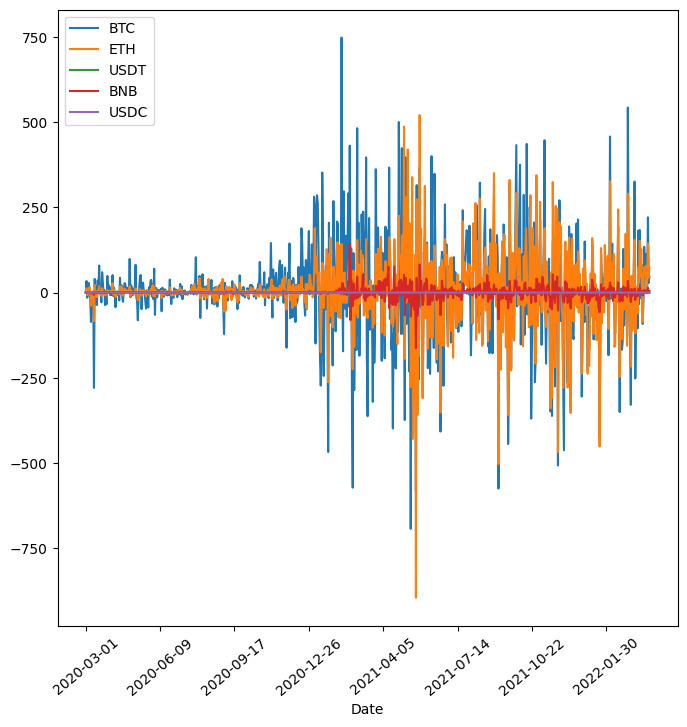

In [896]:
df_merged_change.plot.line(rot=40)